# test DL models

## so much import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import re
import PATH
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split

from matplotlib import pyplot as plt

from models.popen import Auto_popen
from models.ScheduleOptimizer import ScheduledOptim 
from models.log_and_save import Log_parser,plot_a_exp_set
from models import reader
from models import DL_models

from utils import Seq_one_hot,read_UTR_csv,read_label

/home/wergillius/Project/UTR_VAE


### read data

In [2]:
# define data
dataset = reader.UTR_dataset(cell_line='A549')

train_loader,val_loader,test_loader = reader.get_splited_dataloader(dataset,
                                                                    ratio=[0.7,0.2,0.1],
                                                                    batch_size=10,
                                                                    num_workers=4)

In [3]:
train_iter=iter(train_loader)

In [4]:
train_loader.batch_size

10

In [5]:
# from train loader get some data
batch_data = next(train_iter)

X, y = batch_data
X = X.float()
y = y.long()

In [6]:
X.shape , y.shape

(torch.Size([10, 100, 4]), torch.Size([10]))

In [18]:
X_conv=X.transpose(1,2)

## the kernel shape

In [7]:
from utils import cal_convTrans_shape , cal_conv_shape

In [10]:
def cal_convTrans_shape(L_in,kernel_size,padding=0,stride=1,diliation=1,out_padding=0):
    """
    For convolution Transpose 1D decoding , compute the final length
    """
    L_out = (L_in -1 )*stride + diliation*(kernel_size -1 )+1-2*padding + out_padding 
    return L_out

def cal_conv_shape(L_in,kernel_size,padding=0,diliation=1,stride=1):
    """
    For convolution 1D encoding , compute the final length 
    """
    L_out = 1+ (L_in + 2*padding -diliation*(kernel_size-1) -1)/stride
    return L_out

In [20]:
Conv_block = lambda in_chan,out_chan : nn.Sequential(nn.Conv1d(in_chan,out_chan,kernel_size=3,stride=2,padding=))

In [11]:
cal_conv_shape(100,3)

98.0

In [65]:
Chann = [4,16,32,64,128]
pad_ls = [1,0,1,0]
L_in = 100
for i in range(len(Chann)-1):
    L_out = cal_conv_shape(L_in,4,stride=2,padding=pad_ls[i])
    L_in = L_out
    print(L_out)

50.0
24.0
12.0
5.0


In [66]:
Chann = [4,16,32,64,128]
pad_ls = [1,0,1,0]
L_in = 5
for i in range(len(Chann)-1):
    L_out = cal_convTrans_shape(L_in,4,stride=2,padding=pad_ls[::-1][i],out_padding=0)
    L_in = L_out
    print(L_out)

12
24
50
100


In [73]:
Chann = [4,16,32,64,128]
pad_ls = [1,0,1,0]
Conv_sequence = nn.ModuleList(
    [nn.Conv1d(Chann[i],Chann[i+1],4,stride=2,padding=pad_ls[i]) for i in range(len(Chann)-1)]
)
Deconv_sequqnce = nn.ModuleList(
    [nn.ConvTranspose1d(Chann[::-1][i],Chann[::-1][i+1],4,stride=2,padding=pad_ls[::-1][i]) for i in range(len(Chann)-1)]
)

In [74]:
out = X_conv
print("start Conv")
for model in Conv_sequence:
    out = model(out)
    print(out.shape)

start Conv
torch.Size([10, 16, 50])
torch.Size([10, 32, 24])
torch.Size([10, 64, 12])
torch.Size([10, 128, 5])


In [75]:
print("start Deconv")
for model in Deconv_sequqnce:
    out = model(out)
    print(out.shape)

start Deconv
torch.Size([10, 64, 12])
torch.Size([10, 32, 24])
torch.Size([10, 16, 50])
torch.Size([10, 4, 100])


In [81]:
from importlib import reload

In [90]:
from models import CNN_models
reload(CNN_models)

<module 'models.CNN_models' from '/home/wergillius/Project/UTR_VAE/models/CNN_models.py'>

In [91]:
model = CNN_models.Conv_AE(channel_ls=[4,16,32,64,128], padding_ls=[1,0,1,0])

In [94]:
X = X.transpose(1,2)

In [95]:
X.shape

torch.Size([10, 4, 100])

In [96]:
out = model(X)

In [97]:
out.shape

torch.Size([10, 4, 100])

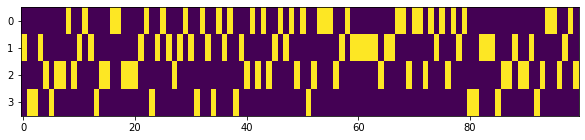

In [155]:
fig,ax = plt.subplots(figsize=(10,2))
ax.imshow(X[0],aspect='auto');

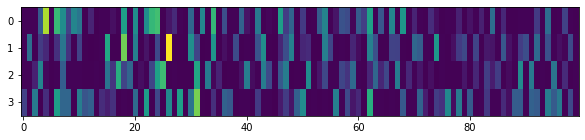

In [156]:
fig,ax = plt.subplots(figsize=(10,2))
ax.imshow(out[0].detach().numpy(),aspect='auto');

In [140]:
def compute_acc(X,out):
    batch_size = X.shape[0]       # B*100*4
    true_max=torch.argmax(X,dim=2)

    recon_max=torch.argmax(out,dim=2)

    return torch.sum(true_max == recon_max).item() 
    

In [152]:
def reconstruct_seq(out_seq,X):
    seq = torch.zeros_like(X)
#     out_seq = torch.cat(out_seq,dim=1)
    position = torch.argmax(out_seq,dim=2)     # X_reconst : b*100*4

    for batch_idx in range(X.shape[0]):
        for i,j in enumerate(position[batch_idx]):
            seq[batch_idx,i,j.item()] = 1     
            
    return torch.mean(X.mul(seq).sum(dim=2).sum(dim=1)) 

In [143]:
%timeit compute_acc(X,out)

519 µs ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [148]:
out_T = out.transpose(1,2)
X_T = X.transpose(1,2)

In [151]:
out_T.shape

torch.Size([10, 100, 4])

In [153]:
%timeit reconstruct_seq(out_T,X_T)

13.2 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
loss_fnc=nn.MSELoss(reduction='mean')


$$    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2,$$

where $N$ is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then:

$$    \ell(x, y) =
    \begin{cases}
        \operatorname{mean}(L), &  \text{if reduction} = \text{'mean';}\\
        \operatorname{sum}(L),  &  \text{if reduction} = \text{'sum'.}
    \end{cases}$$

:$x$ and :$y$ are tensors of arbitrary shapes with a total
of :$n$ elements each 

In [120]:
loss = loss_fnc(out,X)

In [121]:
loss

tensor(2143.4841, grad_fn=<MseLossBackward>)